In [2]:
# default_exp core

# module name here

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [159]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional

In [160]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1}
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [161]:
config = Config()

## URLs -

In [7]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('models' if c_key=='models' else 'data')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [8]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [9]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [10]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [11]:
#export
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
#     if fname.exists() and _get_check(url) and _check_file(fname) != _get_check(url):
#         print("A new version of this dataset is available, downloading...")
#         force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): shutil.rmtree(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
#         if _get_check(url) and _check_file(fname) != _get_check(url):
#             print(f"File downloaded is broken. Remove {fname} and try again.")
        extract_func(fname, dest.parent)
    return dest

In [12]:
#export
def make_df(path):
    "Creates a pandas df from `path`"
    return pd.read_csv(path)

In [83]:
shots_2001 = make_df(untar_data(URLs.SHOTS_2001))

In [84]:
shots_2001.head()

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,80,200110300CLE,2001,10,30,Boston,Cleveland,46px,57px,"1st quarter, 11:33.0 remaining<br>Andre Miller...",11:33.0,1,Andre Miller,missed,2-pointer,18ft,Cleveland,0,0
1,81,200110300CLE,2001,10,30,Boston,Cleveland,97px,279px,"1st quarter, 11:16.0 remaining<br>Chris Mihm m...",11:16.0,1,Chris Mihm,made,2-pointer,6ft,Cleveland,2,2
2,0,200110300CLE,2001,10,30,Boston,Cleveland,67px,224px,"1st quarter, 11:03.0 remaining<br>Antoine Walk...",11:03.0,1,Antoine Walker,missed,2-pointer,2ft,Boston,2,2
3,1,200110300CLE,2001,10,30,Boston,Cleveland,61px,230px,"1st quarter, 10:59.0 remaining<br>Tony Battie ...",10:59.0,1,Tony Battie,missed,2-pointer,1ft,Boston,2,2
4,82,200110300CLE,2001,10,30,Boston,Cleveland,84px,173px,"1st quarter, 10:42.0 remaining<br>Chris Mihm m...",10:42.0,1,Chris Mihm,made,2-pointer,8ft,Cleveland,2,4


## List unique game ids

In [85]:
#export
def list_game_ids(df,year,month,day):
    "Lists unique game ids for a given date"
    return df.loc[(df['year']==year) & (df['month']==month) & (df['day']==day)]['game_id'].drop_duplicates()
    

In [86]:
list_game_ids(shots_2001,2001,11,25)

27879    200111250GSW
28827    200111250TOR
29451    200111250SEA
29606    200111250LAL
30416    200111250LAC
Name: game_id, dtype: object

## Plot winner shot chart

In [174]:
#export
def plot_winner(df:pd.DataFrame, game_id:str,made:bool=True,missed:bool=True,attempt:str="all",distance:Union[str,List[str]]="all"):
    "Plots the shot chart for the winner team of `game_id`"
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    #find winner first
    winner = df.loc[df["game_id"]==game_id].iloc[0]["winner"]
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="3-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    else:
        shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner)]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys,marker="x")
    plt.show()

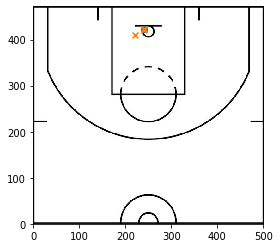

In [173]:
plot_winner(shots_2001,"200111250GSW",attempt="3-pointer",distance=["2ft","0ft"])

In [105]:
#export
def plot_loser(df, game_id,made=True,missed=True):
    "Plots the shot chart for the winner team of `game_id`"
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    #find winner first
    loser = df.loc[df["game_id"]==game_id].iloc[0]["loser"]
    shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser)]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys,marker="x")
    plt.show()

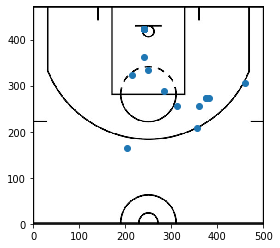

In [106]:
plot_loser(shots_2001,"200111250GSW",missed=False)

## List players who took shots for a team

In [126]:
#export
def list_team_players(df, team):
    return df.loc[df['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [128]:
list_team_players(shots_2001,'LA Lakers')

,shots_by,count
5,Kobe Bryant,1593
13,Shaquille O'Neal,1228
1,Derek Fisher,665
10,Rick Fox,603
2,Devean George,515
6,Lindsey Hunter,490
11,Robert Horry,459
12,Samaki Walker,365
14,Stanislav Medvedenko,303
9,Mitch Richmond,247


## Plot shot chart - player - full season

In [140]:
#export
def plot_player_full(df, player, made=True, missed=True):
    "Plots shot chart of `player` for the full season"
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    #find player
    player_df = df.loc[df['shots_by']==player]
    if made:
        mades_df = player_df.loc[player_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys,color="g")
    if missed:
        misses_df = player_df.loc[player_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [472 - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        plt.scatter(xs,ys,marker="x",color="r")
    plt.show()

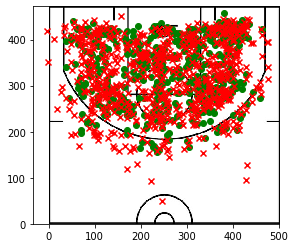

In [141]:
plot_player_full(shots_2001,"Kobe Bryant")

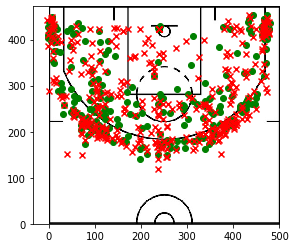

In [142]:
plot_player_full(shots_2001,"Derek Fisher")

### Analyzing dataset

In [143]:
shots_2001.head()

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,80,200110300CLE,2001,10,30,Boston,Cleveland,46px,57px,"1st quarter, 11:33.0 remaining<br>Andre Miller...",11:33.0,1,Andre Miller,missed,2-pointer,18ft,Cleveland,0,0
1,81,200110300CLE,2001,10,30,Boston,Cleveland,97px,279px,"1st quarter, 11:16.0 remaining<br>Chris Mihm m...",11:16.0,1,Chris Mihm,made,2-pointer,6ft,Cleveland,2,2
2,0,200110300CLE,2001,10,30,Boston,Cleveland,67px,224px,"1st quarter, 11:03.0 remaining<br>Antoine Walk...",11:03.0,1,Antoine Walker,missed,2-pointer,2ft,Boston,2,2
3,1,200110300CLE,2001,10,30,Boston,Cleveland,61px,230px,"1st quarter, 10:59.0 remaining<br>Tony Battie ...",10:59.0,1,Tony Battie,missed,2-pointer,1ft,Boston,2,2
4,82,200110300CLE,2001,10,30,Boston,Cleveland,84px,173px,"1st quarter, 10:42.0 remaining<br>Chris Mihm m...",10:42.0,1,Chris Mihm,made,2-pointer,8ft,Cleveland,2,4


## Export -

In [58]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
